<a href="https://colab.research.google.com/github/itamarKraitman/2024DeepLearningCourseProject/blob/main/Main_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.optimizers.legacy import Adam

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import compute_sample_weight

# Objective
This study endeavors to construct a predictive model for estimating the salaries of Data Science positions worldwide, denominated in US dollars (USD).
In this project, a comprehensive dataset contained within a CSV file is explored, encompassing a rich array of information on job roles from a global perspective. The dataset comprises 3,756 records, each detailing various attributes associated with employment positions. These attributes serve as indicators for determining the annual salary (in USD) for each job listed.

## Read Data From Source

In [4]:
data = pd.read_csv('./SalarayDataSet/ds_salaries.csv')

## Data Features
The dataset contains the following features:

1. **work_year**: The year the salary was paid.

2. **experience_level**: The experience level in the job during the year.

3. **employment_type**: The type of employment for the role.

4. **job_title**: The role worked in during the year.

5. **salary**: The total gross salary amount paid.

6. **salary_currency**: The currency of the salary paid as an ISO 4217 currency code.

7. **salary_in_usd**: The salary in USD.

8. **employee_residence**: Employee's primary country of residence in during the work year as an ISO 3166 country code.

9. **remote_ratio**: The overall amount of work done remotely.

10. **company_location**: The country of the employer's main office or contracting branch.

11. **company_size**: The median number of people that worked for the company during the year.

In [3]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


# Exploratory Data Analysis (EDA) - Salary Dataset

## Data Overview
The dataset contains 3755 entries and 11 columns. Below is the description of each column:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


## Verification Of Non-Empty
In order to encode and process the data so that it will be ready for the model, we verify there are no Nan cells.
As shown bellow, all fileds are filled.

In [5]:
data[data.isna().any(axis=1)]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size


## Distribution of Salary (in USD)


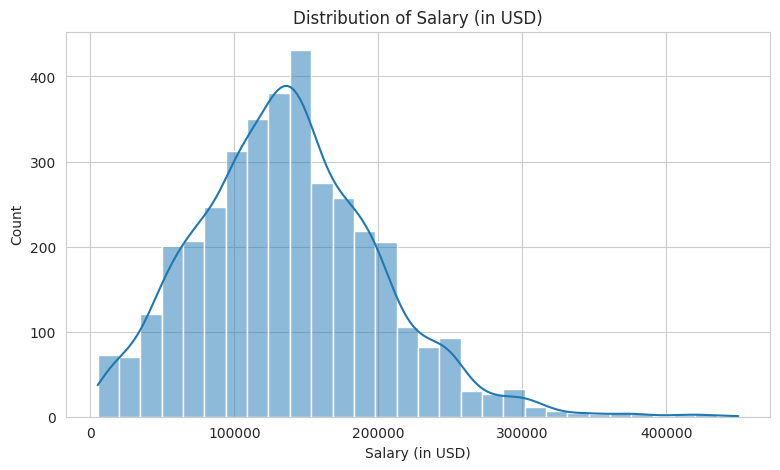

In [10]:
sns.set_style("whitegrid")

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=data, kde=True, bins=30, x='salary_in_usd')
plt.title('Distribution of Salary (in USD)')
plt.xlabel('Salary (in USD)')
plt.ylabel('Count')

plt.show()

## Mean Salary by Position

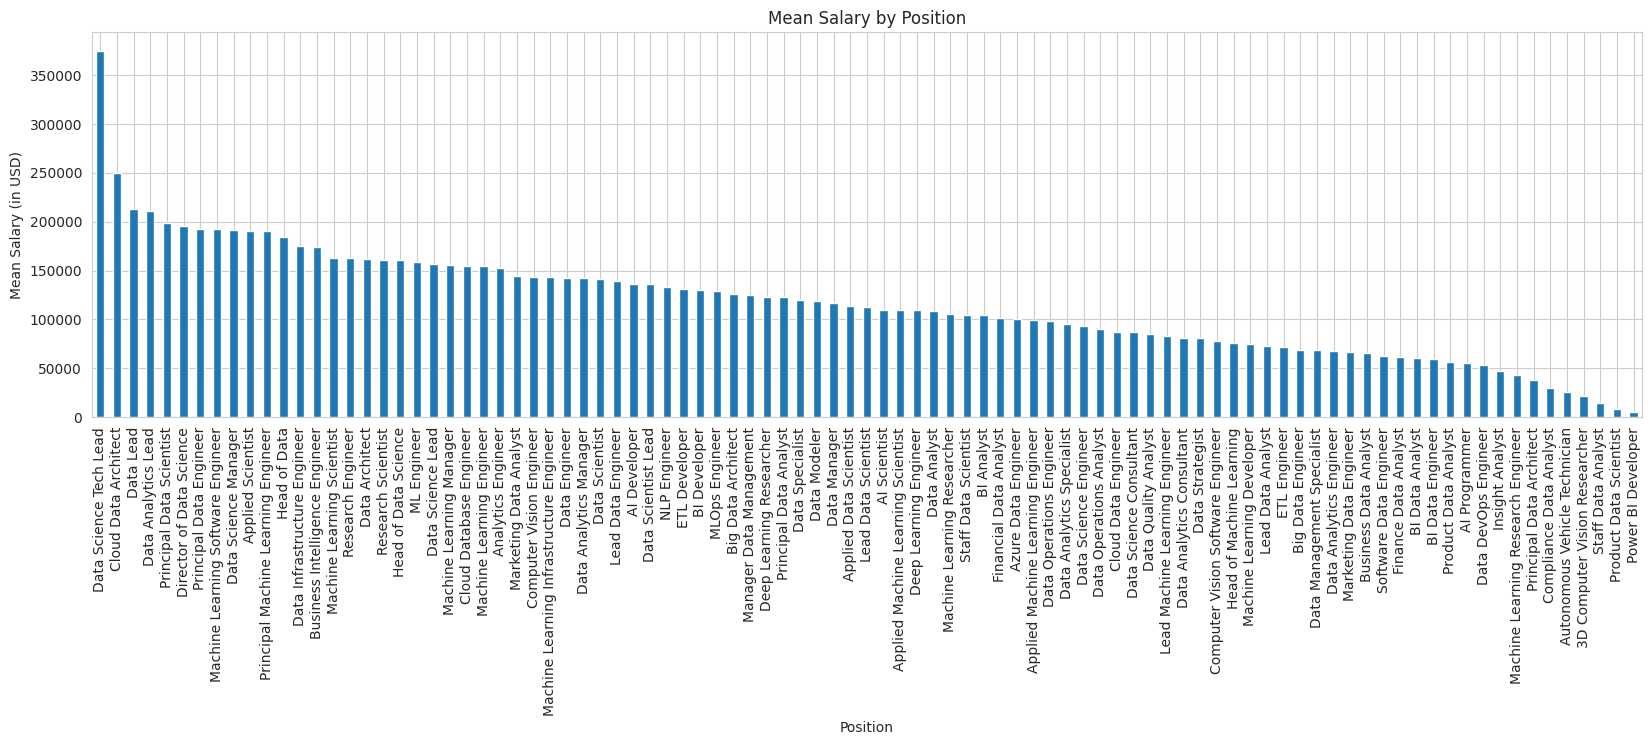

In [8]:
mean_salary_by_position = data.groupby('job_title')['salary_in_usd'].mean()

plt.figure(figsize=(20,5))
mean_salary_by_position.sort_values(ascending=False).plot(kind='bar')
plt.title('Mean Salary by Position')
plt.ylabel('Mean Salary (in USD)')
plt.xlabel('Position')
plt.show()

## Mean Salary by Position

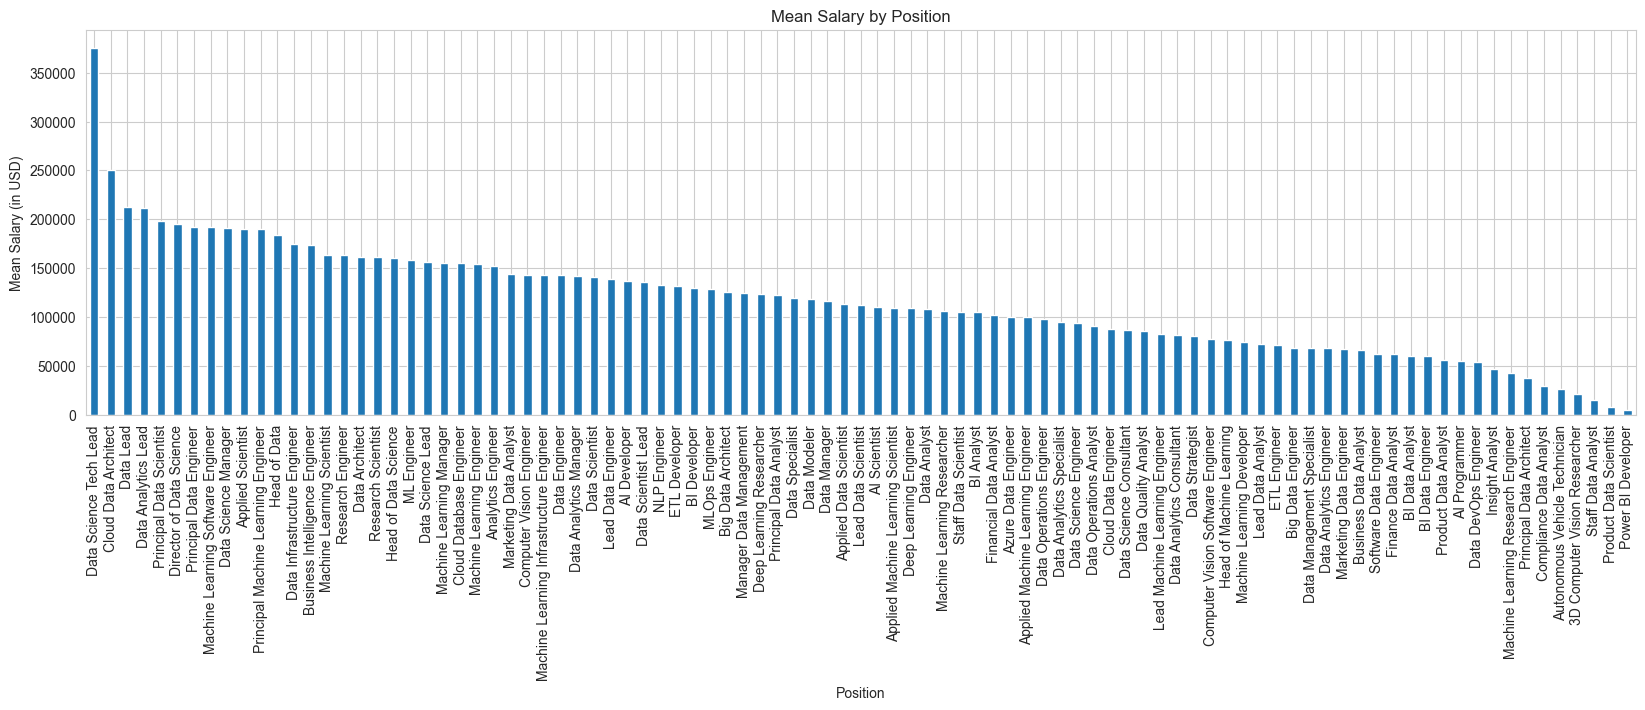

In [11]:
mean_salary_by_position = data.groupby('job_title')['salary_in_usd'].mean()

plt.figure(figsize=(20,5))
mean_salary_by_position.sort_values(ascending=False).plot(kind='bar')
plt.title('Mean Salary by Position')
plt.ylabel('Mean Salary (in USD)')
plt.xlabel('Position')
plt.show()

## Distribution of Salary in USD by Experience Level and Job Title

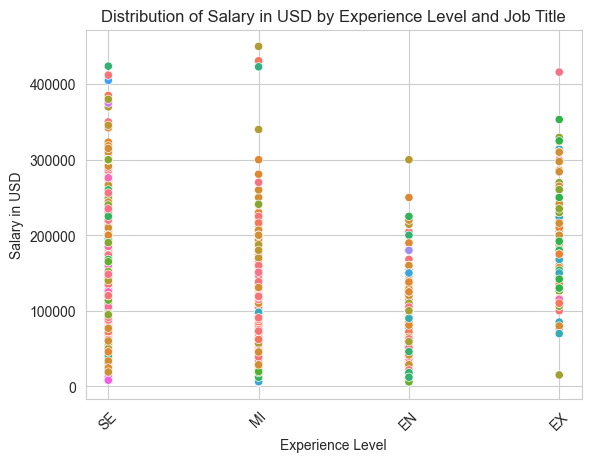

In [12]:
sns.scatterplot(x='experience_level', y='salary_in_usd', hue='job_title', data=data, legend=False)
plt.title('Distribution of Salary in USD by Experience Level and Job Title')
plt.xlabel('Experience Level')
plt.ylabel('Salary in USD')
plt.xticks(rotation=45)
plt.show()

## Distribution of Salary in USD by Work Year

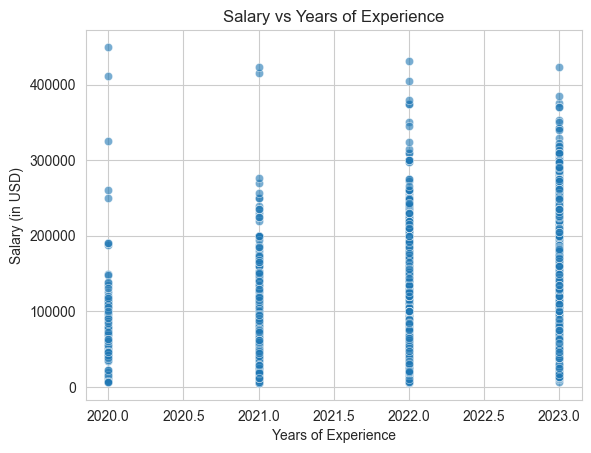

In [13]:
sns.scatterplot(data=data, x='work_year', y='salary_in_usd', alpha=0.6, legend=False)
plt.title('Salary vs Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary (in USD)')
plt.show()

# Data Normalizing and Preprocessing
In order to normalize the data for the training, validation and testing of the model, we identify numeric and categorical features in the dataset and apply appropriate preprocessing transformations.

## Categorical features

In [14]:
objects = data.select_dtypes(include='object')
objects.head()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
0,SE,FT,Principal Data Scientist,EUR,ES,ES,L
1,MI,CT,ML Engineer,USD,US,US,S
2,MI,CT,ML Engineer,USD,US,US,S
3,SE,FT,Data Scientist,USD,CA,CA,M
4,SE,FT,Data Scientist,USD,CA,CA,M


## Normalizing Salary Columns
This section normalizes the 'salary' and 'salary_in_usd' columns by dividing their values by 100,000. Normalization is performed to scale the values within a similar range, which can help improve the convergence of machine learning algorithms during training.

In [15]:
cols_to_normalize = ['salary', 'salary_in_usd']
data[cols_to_normalize] = data[cols_to_normalize] / 100000

data[cols_to_normalize]

,salary,salary_in_usd
0,0.800,0.85847
1,0.300,0.30000
2,0.255,0.25500
3,1.750,1.75000
4,1.200,1.20000
...,...,...
3750,4.120,4.12000
3751,1.510,1.51000
3752,1.050,1.05000
3753,1.000,1.00000


## Preprocessing and Splitting

In this section, we preprocess the dataset and split it into training and validation sets.

### Feature-Target Separation
We separate the feature matrix `data_X` from the target variable `y` in the dataset.

In [16]:
data_X = data.drop('salary_in_usd', axis=1)
y = data['salary_in_usd']

### Numeric and Categorical Feature Processing
We identify numeric and categorical features in the dataset and apply appropriate preprocessing transformations.

In [17]:
numeric_features = data_X.select_dtypes(include=[np.number])
numeric_transformer = StandardScaler()

categorical_features = data_X.select_dtypes(include=['object'])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])

### Dataset Splitting
We split the dataset into training and validation sets using a specified test size and random state.

In [18]:
indices = data.index
train_indices, valid_indices = train_test_split(indices, test_size=0.4, random_state=42)
x_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
x_valid, y_valid = data_X.loc[valid_indices, :], y.loc[valid_indices]


### Applying Transformers 
We apply the preprocessing transformers to the training and validation feature sets.

In [19]:
X_train_preprocessed = preprocessor.fit_transform(x_train)
X_valid_preprocessed = preprocessor.transform(x_valid)

# Convolutional Neural Network (CNN) Modeling

This section outlines the implementation of Convolutional Neural Network (CNN) model.

## CNN Model Definition
CNN model is defined using the Keras Sequential API. The model consists of convolutional layers with ReLU activation functions, max-pooling layers for downsampling, and dense layers for regression.

In [20]:
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(242, 1)),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(1)
])

## Model Compilation
The CNN model is compiled using the Adam optimizer, mean squared error (MSE) as the loss function, and mean absolute error (MAE) and mean squared error (MSE) as the metrics.

In [21]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae', 'mse'])


cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 120, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 118, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 59, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 57, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 28, 128)           0

## Model Training
The CNN model is trained on the preprocessed training data. The `fit` method is used to train the models with specified epochs, batch size, and verbose mode.

In [22]:
cnn_model_history = cnn_model.fit(X_train_preprocessed, y_train,
                                  validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2,
                    )

Epoch 1/400


71/71 - 1s - loss: 0.9565 - mae: 0.7739 - mse: 0.9565 - val_loss: 0.3656 - val_mae: 0.4624 - val_mse: 0.3656 - 951ms/epoch - 13ms/step
Epoch 2/400
71/71 - 1s - loss: 0.3154 - mae: 0.4350 - mse: 0.3154 - val_loss: 0.3045 - val_mae: 0.4134 - val_mse: 0.3045 - 601ms/epoch - 8ms/step
Epoch 3/400
71/71 - 1s - loss: 0.2756 - mae: 0.4008 - mse: 0.2756 - val_loss: 0.2895 - val_mae: 0.4040 - val_mse: 0.2895 - 611ms/epoch - 9ms/step
Epoch 4/400
71/71 - 1s - loss: 0.2645 - mae: 0.3912 - mse: 0.2645 - val_loss: 0.2847 - val_mae: 0.4038 - val_mse: 0.2847 - 597ms/epoch - 8ms/step
Epoch 5/400
71/71 - 1s - loss: 0.2590 - mae: 0.3878 - mse: 0.2590 - val_loss: 0.2818 - val_mae: 0.3911 - val_mse: 0.2818 - 608ms/epoch - 9ms/step
Epoch 6/400
71/71 - 1s - loss: 0.2544 - mae: 0.3824 - mse: 0.2544 - val_loss: 0.2773 - val_mae: 0.3984 - val_mse: 0.2773 - 614ms/epoch - 9ms/step
Epoch 7/400
71/71 - 1s - loss: 0.2497 - mae: 0.3781 - mse: 0.2497 - val_loss: 0.2737 - val_mae: 0.3849 - val_mse: 0.2737 - 565ms/epoch 

## Prediction 
After training, the performance of the model is evaluated on the validation set using MSE and MAE metrics.

In [23]:
y_pred = cnn_model.predict(X_valid_preprocessed)
y_pred

47/47 [==============================] - 0s 4ms/step


array([[1.6840657],
       [1.8168092],
       [1.4517124],
       ...,
       [2.2751043],
       [0.9052747],
       [1.0603546]], dtype=float32)

# Results

# Results

## Model's Prediction Performance
When the data points closely align with the regression line, it indicates that the predicted values are close to the actual values, suggesting that the model's predictions are accurate. Conversely, if the data points are scattered far from the regression line, it suggests a larger discrepancy between the predicted and actual values, indicating poorer performance of the model.

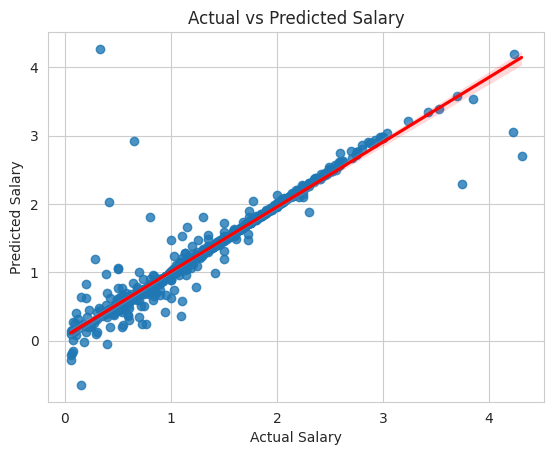

In [24]:
sns.regplot(x=y_valid, y=y_pred, line_kws={"color": "red"})
plt.title('Actual vs Predicted Salary')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

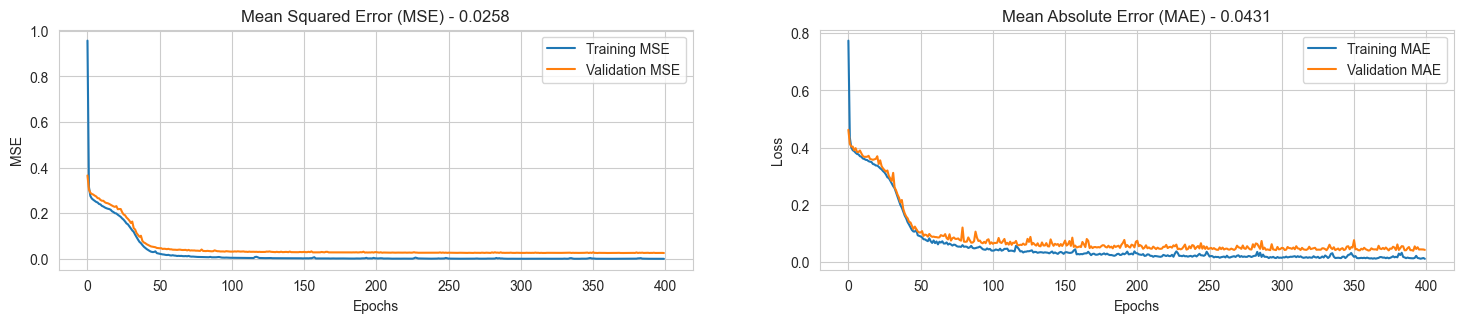

Mean Squared Error (MSE): 0.0258
Mean Absolute Error (MAE): 0.0431


In [25]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

mse = mean_squared_error(y_valid, y_pred)
axs[0].plot(cnn_model_history.history['mse'], label='Training MSE')
axs[0].plot(cnn_model_history.history['val_mse'], label='Validation MSE')
axs[0].set_title(f'Mean Squared Error (MSE) - {mse:.4f}')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[0].legend()
axs[0].grid(True)
axs[0].legend()

mae = mean_absolute_error(y_valid, y_pred)
axs[1].plot(cnn_model_history.history['mae'], label='Training MAE')
axs[1].plot(cnn_model_history.history['val_mae'], label='Validation MAE')
axs[1].set_title(f'Mean Absolute Error (MAE) - {mae:.4f}')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].legend()

plt.subplots_adjust(top=0.4, bottom=0.0)
plt.show()
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')